# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**

This project aims to forecast national monthly car sales in South Africa (who: automotive industry stakeholders) by integrating historical vehicle sales data with behavioral signals from Google Trends search indices (what). Using data spanning from 2010 Jan to 2025 Jan (when) and focusing on the South African automotive market (where), the study addresses why traditional forecasting methods—based only on past sales—often fail to capture rapid shifts in consumer interest and external market changes. To overcome this, the research compares traditional time-series models (SARIMA, LSSVR) with deep learning models (LSTM, CNN-LSTM, BiLSTM), both with and without online search data, to evaluate the added predictive value of behavioral signals (how). Finally, the best-performing deep learning models are interpreted using SHAP analysis to reveal which features most influence forecasts, supporting more data-driven, transparent, and responsive decision-making for manufacturers, dealerships, and analysts.

#### **Datasets:**

<table style="width:100%">
  <thead>
    <tr>
      <th>Name</th>
      <th>Start Date</th>
      <th>End Date</th>
      <th>Source</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Motor Trade Sales.xlsx</td>
      <td>01-1998</td>
      <td>05-2025</td>
      <td>CEIC Data</td>
      <td>Revenue generated each month from sales</td>
    </tr>
    <tr>
      <td>Motor Vehicle Sales Monthly South Africa.xlsx</td>
      <td>01-2003</td>
      <td>06-2025</td>
      <td>CEIC Data</td>
      <td>Number of units sold each month</td>
    </tr>
    <tr>
      <td>Autos_Vehicles_Category.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The overall interest in the Autos Vehicles category on Google Trends</td>
    </tr>
    <tr>
      <td>Queries_Rising.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently rising queries related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Queries_Top.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently top queries related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Topic_Rising.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently rising topics related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Topic_Top.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently top topics related to the automotive category in Google Trends</td>
    </tr>
  </tbody>
</table>


##### **Important Descriptions**
+ Interest over time from Google Trends:

    *Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means that there was not enough data for this term.*

## 1. Libraries

In [31]:
#! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl pmdarima tensorflow

In [1]:
import itertools
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import os, joblib
import openpyxl
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from pmdarima.arima.utils import ndiffs

## 2. Importing datasets

In [2]:
sales = pd.read_excel("Motor Trade Sales.xlsx", sheet_name="My Series")

vol = pd.read_excel("Motor Vehicle Sales Monthly South Africa.xlsx",  sheet_name="My Series")

In [3]:
print(sales.info())
print("="*50)
print(vol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    329 non-null    datetime64[ns]
 1   Sales   329 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    270 non-null    datetime64[ns]
 1   Volume  270 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.3 KB
None


In [4]:
# Google trends data preperation
def load_and_merge_google_trends_data(folder_path):
    merged_df = None
    folder = Path(folder_path)
    
    for file in folder.glob("*.csv"):
        keyword = file.stem  # Get filename without extension
        df = pd.read_csv(file, skiprows=2)
        
        # Rename the value column using the keyword (assumes 2 columns: Month + keyword)
        if df.shape[1] > 1:
            df.columns = ['Month', keyword]
        else:
            continue  # skip malformed file

        # Merge into final dataset
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='Month', how='outer')

    # Optional: sort by Month
    if merged_df is not None:
        merged_df.sort_values('Month', inplace=True)
    
    return merged_df


# Example usage:
base_path = "./GoogleTrends"
output_dir = "./Processed_Trends"
os.makedirs(output_dir, exist_ok=True)

folders = {
    "queries_rising": os.path.join(base_path, "Queries", "Rising"),
    "queries_top": os.path.join(base_path, "Queries", "Top"),
    "topics_rising": os.path.join(base_path, "Topics", "Rising"),
    "topics_top": os.path.join(base_path, "Topics", "Top")
}

# Process and save
for name, path in folders.items():
    merged = load_and_merge_google_trends_data(path)
    if merged is not None:
        merged.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)
        print(f"Saved: {name}.csv")
    else:
        print(f"No data found for: {name}")

Saved: queries_rising.csv
Saved: queries_top.csv
Saved: topics_rising.csv
Saved: topics_top.csv


## 3. Data Preparation

   1. We will limit the range of observation to 01-2004 to 05-2025, since that is where they all overlap. (This will act as a form of balancing the datasets)
   2. Make sure the "Date" column is in datetime format, and is the index of the dataframe.
   3. Shift the days to the last of the month

In [5]:
def limit_date_range(df, date_column):
    # Replace "<1" values (strings) with 0 across all columns
    df.replace("<1", 0, inplace=True)
    # Convert to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce', format='%Y-%m')
    # Shift dates to end of month
    df[date_column] = df[date_column].dt.to_period('M').dt.to_timestamp('M')
    # Define boundaries
    start_date = pd.to_datetime('2004-01')
    end_date = pd.to_datetime('2025-05')
    # Filter by date range
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
    return df


sales = limit_date_range(sales, 'Date')
vol = limit_date_range(vol, 'Date')

# Path to the folder
folder_path = "./Processed_Trends"
os.makedirs(folder_path, exist_ok=True)

# Apply filter to all CSVs in folder
for file in Path(folder_path).glob("*.csv"):
    try:
        final_df = pd.read_csv(file)
        # Rename 'Month' column to 'Date'
        if 'Month' in final_df.columns:
            final_df.rename(columns={'Month': 'Date'}, inplace=True)
        # Limit date range
        df_filtered = limit_date_range(final_df, 'Date')
        
        # Save the filtered dataframe
        out_file = Path(folder_path) / file.name
        df_filtered.to_csv(out_file, index=False)
        print(f"Filtered and saved: {out_file.name}")
    except Exception as e:
        print(f"Failed to process {file.name}: {e}")

Filtered and saved: queries_rising.csv
Filtered and saved: queries_top.csv
Filtered and saved: topics_rising.csv
Filtered and saved: topics_top.csv


In [6]:
# Here will will set the index of sales and vol dataframes to 'Date'
sales.set_index("Date", inplace=True)
vol.set_index("Date", inplace=True)

In [7]:
# Combining both series into one DataFrame
combined_df = pd.concat([
    sales.rename(columns={sales.columns[0]: 'Sales (Rmn)'}),
    vol.rename(columns={vol.columns[0]: 'Volume'})
], axis=1)

# Reset index to get date as a column
combined_df = combined_df.reset_index().rename(columns={'index': 'Date'})

# Melt to long format for seaborn lineplot
long_df = combined_df.melt(id_vars='Date', value_vars=['Sales (Rmn)', 'Volume'], 
                           var_name='Type', value_name='Value')

## 4. Data Understanding

### a. Time Series Plots

#### (i) Sales and Volume Time Series Plots

In [8]:
# Create interactive Plotly line chart
fig = px.line(
    long_df,
    x='Date',
    y='Value',
    color='Type',
    title='Sales and Volume Over Time',
    labels={'Value': 'Value/Count', 'Date': 'Date', 'Type': 'Legend'}
)

# Optional: Style tweaks
fig.update_layout(
    template='plotly_white',
    legend_title_text='Type',
    xaxis_title='Date',
    yaxis_title='Value/Count'
)

# Show the plot
fig.show()


##### *Interpretation:*

The graph shows an overall increase in sales (in millions) over the year with the volume of vehicles sold remaining in the 20-60 thousand range. In the early 2000's the volume of vehicles sold was more than the money generated, and it started maintaing the same trend up until 2016. After this the industry started focusing on maximizing profit. 

In early 2020, there was a sharp decline in both sales and volume. This was caused by the shut down of the country due to the Covid-19 Pandemic.[https://www.cars.co.za/motoring-news/new-car-sales-in-sa-march-2020/77385/]

**Key Takeaway:**
The outputs have a clear outlier during the early days of Covid so we will need to remedy that at some point.

#### (ii) Google Trends Time Series Plots

In [9]:
# Path to the folder
folder_path = "./Processed_Trends"
os.makedirs(folder_path, exist_ok=True)

# Apply filter and plot all CSVs
for file in Path(folder_path).glob("*.csv"):
    try:
        # Load the CSV and parse the index as datetime
        final_df = pd.read_csv(file, index_col=0, parse_dates=True)

        # Reset index to make 'Date' a column for Plotly
        df_reset = final_df.reset_index().rename(columns={final_df.index.name: 'Date'})

        # Melt to long format
        df_melted = df_reset.melt(id_vars='Date', var_name='Keyword', value_name='Interest')

        # Plot with Plotly
        fig = px.line(
            df_melted,
            x='Date',
            y='Interest',
            color='Keyword',
            title=f"{file.stem} Trends",
            labels={'Interest': 'Interest Level', 'Date': 'Date', 'Keyword': 'Keyword'}
        )

        fig.update_layout(
            template='plotly_white',
            legend_title_text='Keyword',
            xaxis_title='Date',
            yaxis_title='Interest Level'
        )

        fig.show()

    except Exception as e:
        print(f"Failed to plot {file.name}: {e}")

##### *Interpretation:*

So far all the graphs for the Google trends data is nonsensical, we will have to dig deeper at a later stage to extract some information from them.

### b. STL Plots for Sales and Volume

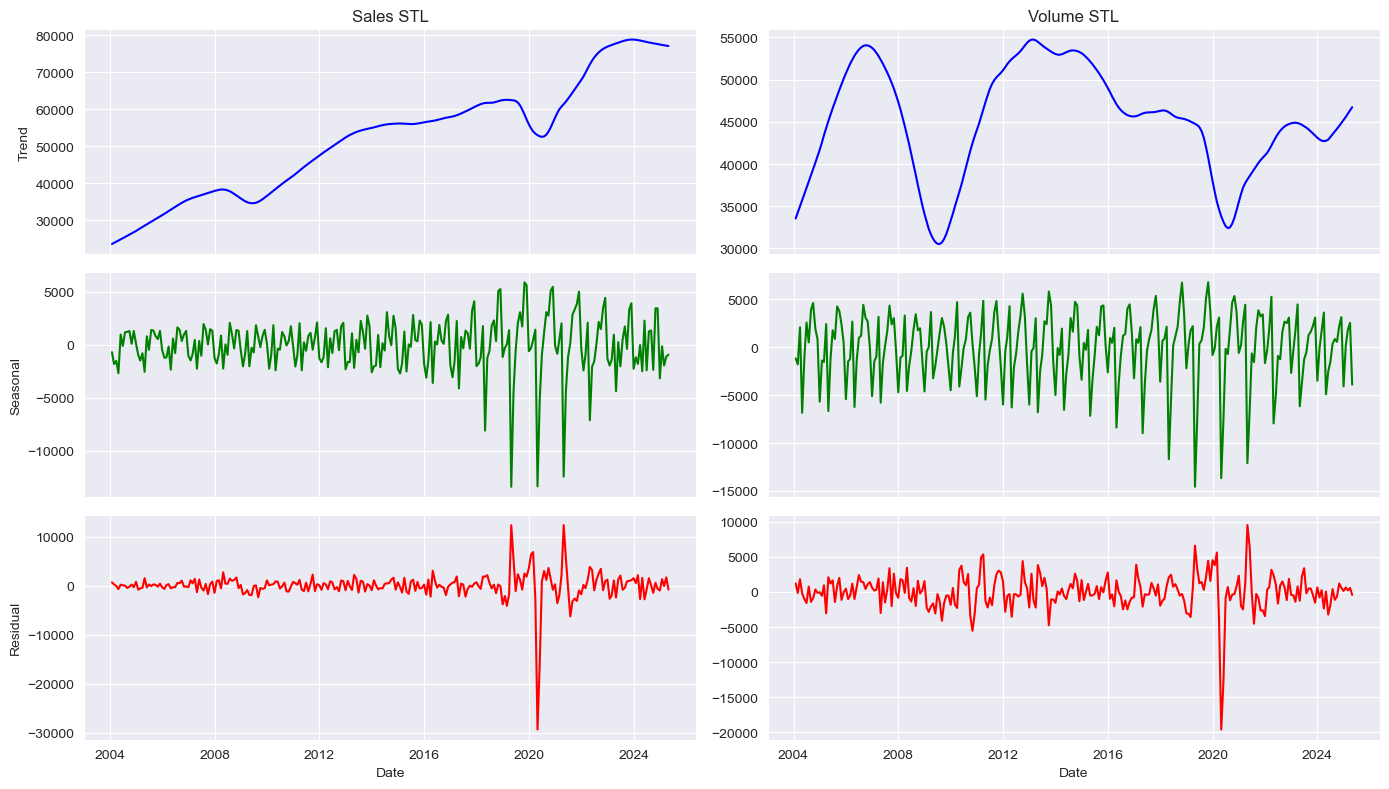

In [10]:
# Perform STL decomposition
stl_sales = STL(sales['Sales'], period=12).fit()
stl_vol = STL(vol['Volume'], period=12).fit()

# Create side-by-side subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 8), sharex=True)

# Titles for each subplot column
axes[0, 0].set_title('Sales STL')
axes[0, 1].set_title('Volume STL')

# Plot Trend
axes[0, 0].plot(stl_sales.trend, label='Trend', color='blue')
axes[0, 1].plot(stl_vol.trend, label='Trend', color='blue')

# Plot Seasonal
axes[1, 0].plot(stl_sales.seasonal, label='Seasonal', color='green')
axes[1, 1].plot(stl_vol.seasonal, label='Seasonal', color='green')

# Plot Residual
axes[2, 0].plot(stl_sales.resid, label='Residual', color='red')
axes[2, 1].plot(stl_vol.resid, label='Residual', color='red')

# Y-axis labels
axes[0, 0].set_ylabel('Trend')
axes[1, 0].set_ylabel('Seasonal')
axes[2, 0].set_ylabel('Residual')

# X-axis label on bottom row
axes[2, 0].set_xlabel('Date')
axes[2, 1].set_xlabel('Date')

# Tight layout
plt.tight_layout()
plt.show()


##### **Intepretation:**

<table style="width:100%; border-collapse: collapse;" border="1">
  <thead>
    <tr>
      <th style="padding:8px;"><strong>Component</strong></th>
      <th style="padding:8px;"><strong>Sales</strong></th>
      <th style="padding:8px;"><strong>Volume</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;"><strong>Trend</strong></td>
      <td style="padding:8px;">
        There’s a clear upward trend from 2004 to around 2015, followed by a plateau between 2015–2018.
        A sharp dip is observed in 2020 (COVID-19), with strong recovery post-2021 and slight softening at the end.
      </td>
      <td style="padding:8px;">
        Starts high, rises until ~2006, then declines to 2009. Stabilizes between 2010–2016,
        then dips sharply in 2020 (pandemic) with partial recovery after. More volatile than Sales.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Seasonality</strong></td>
      <td style="padding:8px;">
        Strong and consistent annual cycles. Peaks and troughs repeat regularly with slightly amplified fluctuations post-2019.
      </td>
      <td style="padding:8px;">
        Seasonal swings are more intense than in Sales. Regular cycles persist but become more erratic post-2020.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Residuals</strong></td>
      <td style="padding:8px;">
        Mostly stable around zero, with outliers during 2020 (COVID shock). Suggests low noise and well-behaved time series.
      </td>
      <td style="padding:8px;">
        Similar residual shape as Sales, but with slightly higher volatility and noise, especially post-2018.
        Strong outliers in 2020.
      </td>
    </tr>
  </tbody>
</table>


### c. ACF/PACF Plots for volume and sales

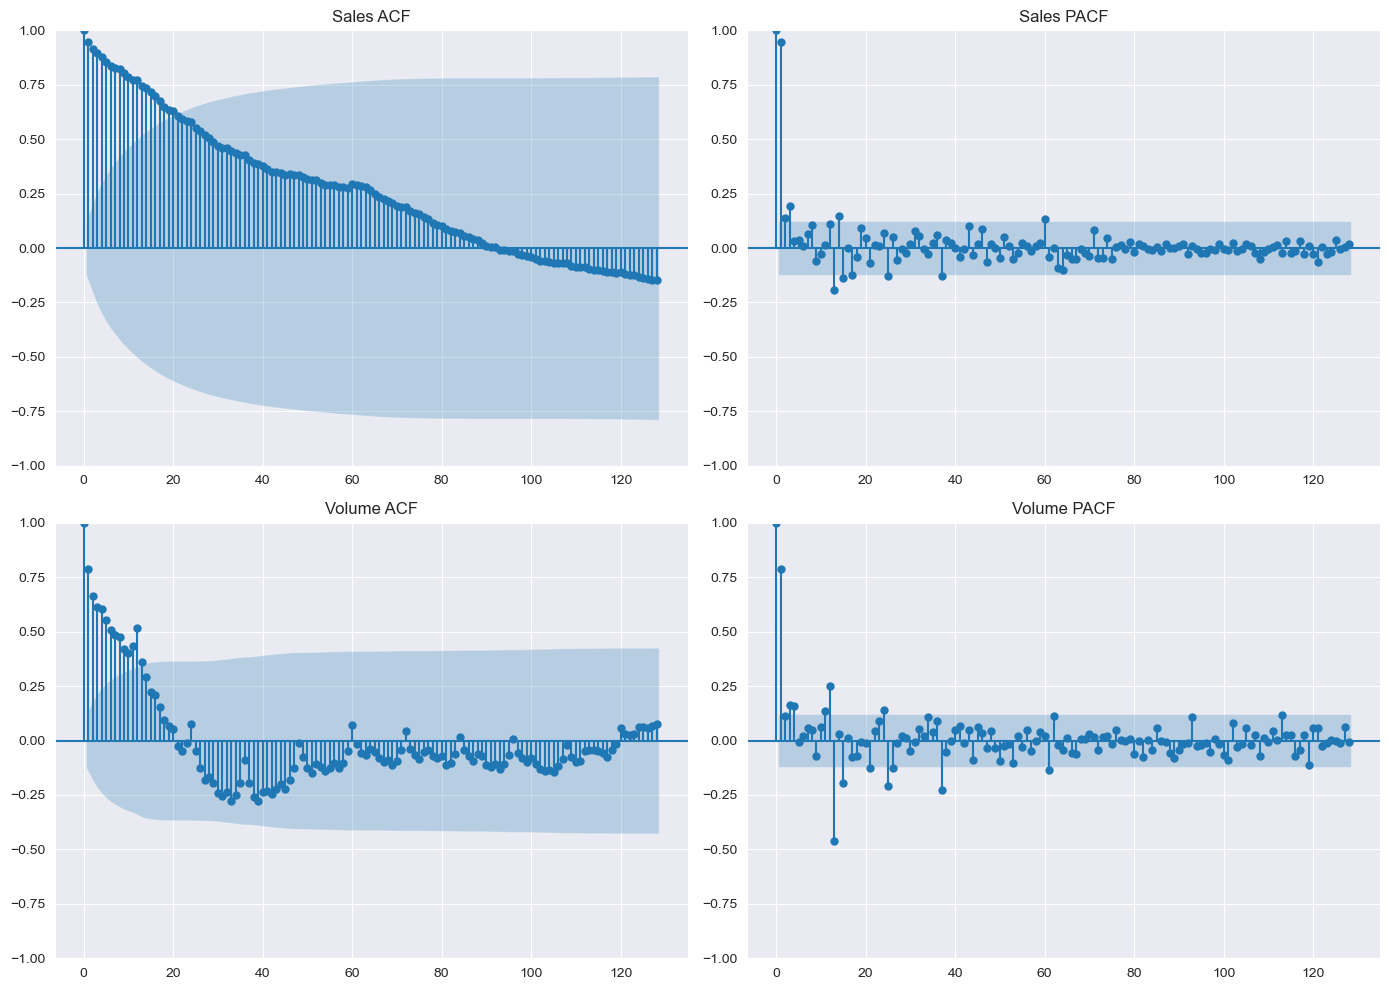

In [11]:
# Assuming sales and vol are DataFrames with one column each:
sales_series = sales["Sales"]
vol_series = vol["Volume"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sales ACF
plot_acf(sales_series, ax=axes[0, 0], lags=len(vol)//2)
axes[0, 0].set_title('Sales ACF')

# Sales PACF
plot_pacf(sales_series, ax=axes[0, 1], lags=len(vol)//2, method='ywm')
axes[0, 1].set_title('Sales PACF')

# Volume ACF
plot_acf(vol_series, ax=axes[1, 0], lags=len(vol)//2)
axes[1, 0].set_title('Volume ACF')

# Volume PACF
plot_pacf(vol_series, ax=axes[1, 1], lags=len(vol)//2, method='ywm')
axes[1, 1].set_title('Volume PACF')

plt.tight_layout()
plt.show()

##### **Intepretation:**

<table style="width:100%; border-collapse: collapse;" border="1">
  <thead>
    <tr>
      <th style="padding:8px;"><strong>Component</strong></th>
      <th style="padding:8px;"><strong>ACF</strong></th>
      <th style="padding:8px;"><strong>PACF</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;"><strong>Sales</strong></td>
      <td style="padding:8px;">
        There is a High Positive Autocorrelation at at very low lags then slowly declining toward zero. This suggests that current sales vales are heavily dependent on previous sales values (Non-Stationarity)
      </td>
      <td style="padding:8px;">
        There is a large spike at lag 1, followed by much smaller spikes within confidence bounds. This indicates that lag 1 has the strongest direct effect on current sales once other lags are controlled for.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Volume</strong></td>
      <td style="padding:8px;">
        There is a High Positive Autocorrelation at low lags but decays faster compared to sales.
        There are also noticable oscillations around zero from lag 20 onwards, which confirms the seasonal patterns identified in the Seasonality plot. 
      </td>
      <td style="padding:8px;">
        There is a strong spike at lag 1, smaller spikes at lags 2 and beyond. Most other lags stay within the confidence interval, except for a few spikes. 
      </td>
    </tr>
  </tbody>
</table>

##### **Overall Conclusion:**

+ Therefore both figures need stationarity testing (ADF) before model fitting.

## 5. Final Data Preparation

### a. Dataset Merger

In [12]:
# remember we already have a dataset that has the sales and volume fields
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         256 non-null    datetime64[ns]
 1   Sales (Rmn)  256 non-null    int64         
 2   Volume       256 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.1 KB


In [13]:
# Ensure main DataFrame has Date as index
combined_df.set_index('Date', inplace=True)
final_df = combined_df.copy()

# Path to folder
folder_path = Path('./Processed_Trends')

for file in folder_path.glob("*.csv"):
    try:
        temp_df = pd.read_csv(file, index_col=0, parse_dates=True)
        suffix = file.stem.lower().replace(" ", "_")
        
        # Rename columns to avoid overlaps
        temp_df = temp_df.rename(columns={col: f"{col}_{suffix}" for col in temp_df.columns})
        
        # Merge temp_df into final_df
        final_df = final_df.join(temp_df, how='left')
        print(f"Merged: {file.name}")
        
    except Exception as e:
        print(f"Failed to process {file.name}: {e}")

print("Final combined shape:", final_df.shape)
final_df.head() 

Merged: queries_rising.csv
Merged: queries_top.csv
Merged: topics_rising.csv
Merged: topics_top.csv
Final combined shape: (256, 43)


,Sales (Rmn),Volume,ford_figo_queries_rising,golf_6_gti_queries_rising,golf_7_gti_queries_rising,gwm_queries_rising,hyundai_i10_queries_rising,hyundai_i20_queries_rising,polo_vivo_queries_rising,toyota_corolla_for_sale_queries_rising,...,toyota_fortuner_topics_rising,volkswagen_tiguan_topics_rising,audi_topics_top,bmw_topics_top,car_topics_top,ford_topics_top,mercedes_topics_top,toyota_topics_top,volkswagen_topics_top,volkwagen_polo_topics_top
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,23578,33601,0,0,0,0,0,0,0,0,...,0,0,42,63,76,29,54,45,67,0
2004-02-29,22343,32338,0,0,0,0,0,0,0,0,...,0,0,53,56,79,33,57,42,58,0
2004-03-31,22645,38892,100,0,0,0,0,0,0,0,...,0,0,45,59,76,39,53,44,35,0
2004-04-30,21155,28681,0,0,0,0,0,0,0,0,...,0,0,37,51,64,30,42,46,65,0
2004-05-31,26024,34347,0,0,0,0,0,0,0,0,...,0,0,37,55,75,31,54,48,58,0


### b. Correlation Heatmap

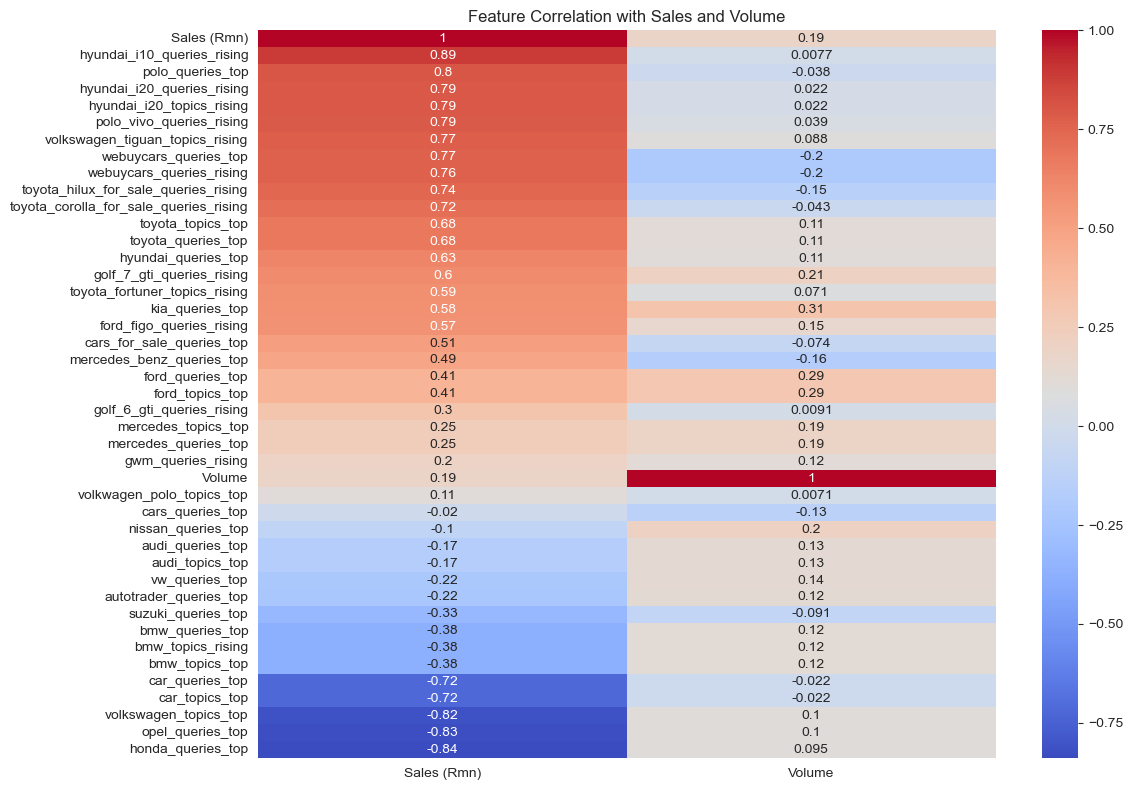

In [14]:
# Check correlations with Sales and Volume
correlation = final_df.corr(numeric_only=True)

# Heatmap of correlations with Sales and Volume
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['Sales (Rmn)', 'Volume']].sort_values(by='Sales (Rmn)', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Sales and Volume")
plt.tight_layout()
plt.show()

### c. Outlier Management

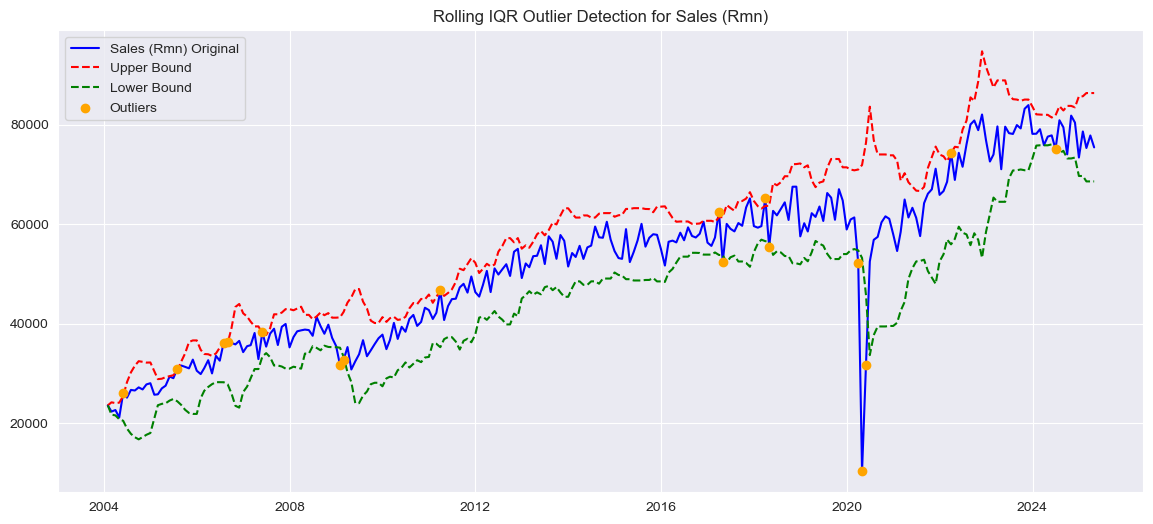

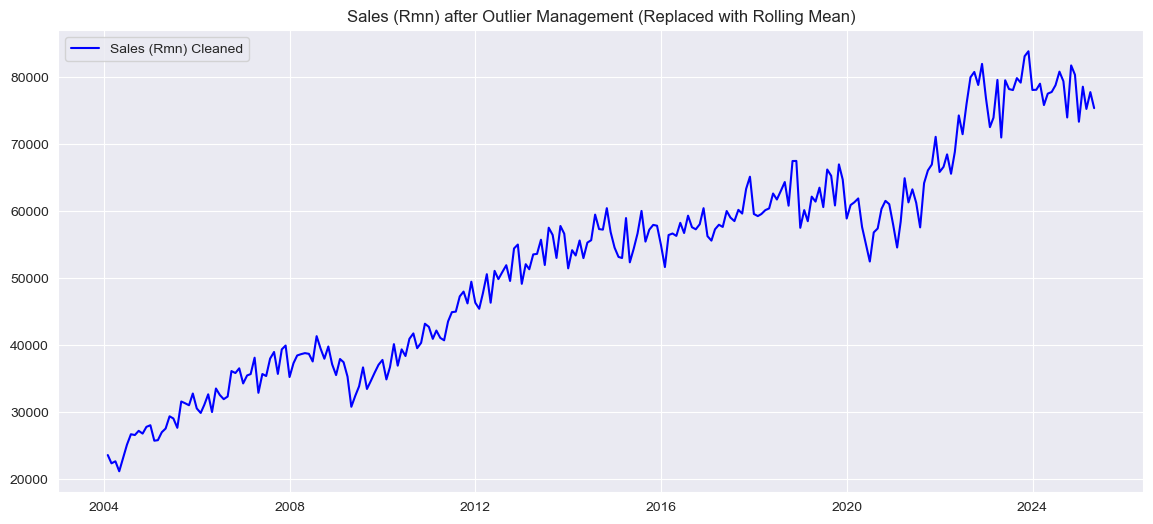

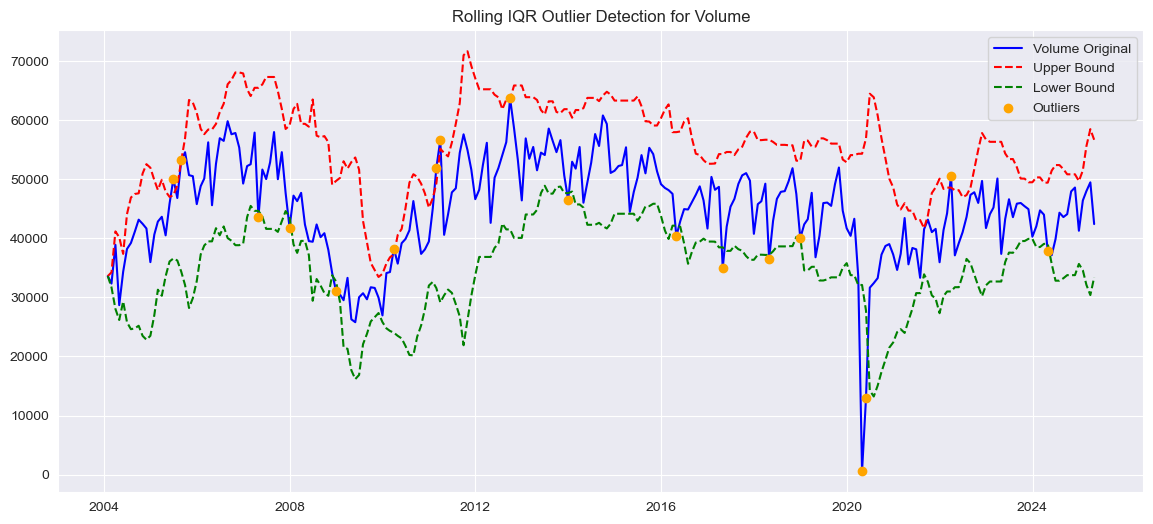

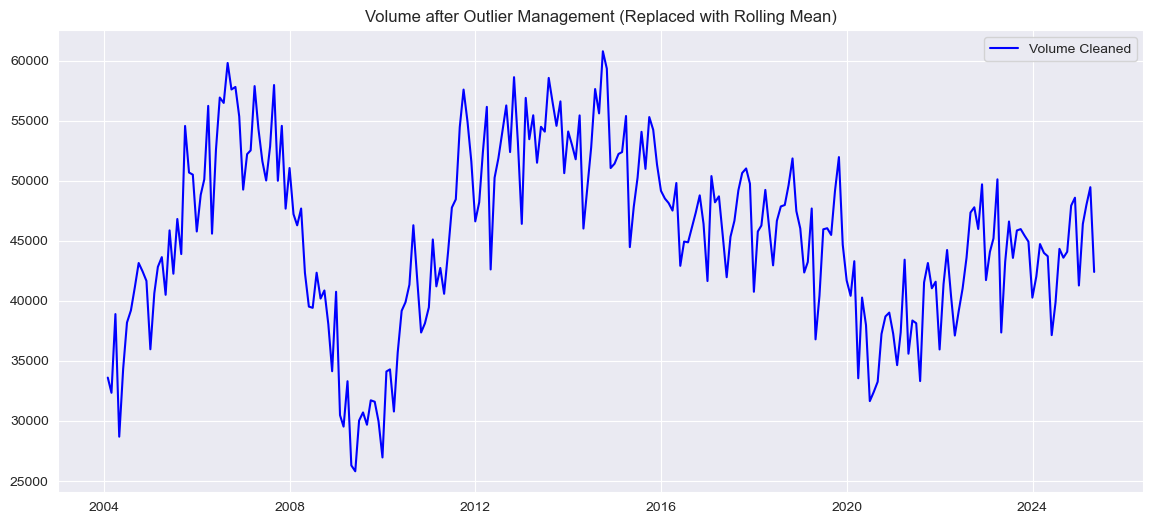

In [15]:
# Parameters
window = 12
columns_to_check = ['Sales (Rmn)', 'Volume']

for col in columns_to_check:
    # Rolling Q1, Q3, IQR
    rolling_Q1 = final_df[col].rolling(window=window, min_periods=1).quantile(0.25)
    rolling_Q3 = final_df[col].rolling(window=window, min_periods=1).quantile(0.75)
    rolling_IQR = rolling_Q3 - rolling_Q1
    
    lower_bound = rolling_Q1 - 1.5 * rolling_IQR
    upper_bound = rolling_Q3 + 1.5 * rolling_IQR
    
    outliers = (final_df[col] < lower_bound) | (final_df[col] > upper_bound)
    
    # Plot Original + Outliers
    plt.figure(figsize=(14,6))
    plt.plot(final_df.index, final_df[col], label=f'{col} Original', color='blue')
    plt.plot(final_df.index, upper_bound, color='red', linestyle='--', label='Upper Bound')
    plt.plot(final_df.index, lower_bound, color='green', linestyle='--', label='Lower Bound')
    plt.scatter(final_df.index[outliers], final_df[col][outliers], color='orange', label='Outliers', zorder=5)
    plt.legend()
    plt.title(f"Rolling IQR Outlier Detection for {col}")
    plt.show()
    
    # Replace Outliers with Rolling Mean
    rolling_mean = final_df[col].rolling(window=window, min_periods=1).mean()
    final_df.loc[outliers, col] = rolling_mean[outliers]
    
    # Plot Cleaned Series
    plt.figure(figsize=(14,6))
    plt.plot(final_df.index, final_df[col], label=f'{col} Cleaned', color='blue')
    plt.legend()
    plt.title(f"{col} after Outlier Management (Replaced with Rolling Mean)")
    plt.show()


### d. Denoising

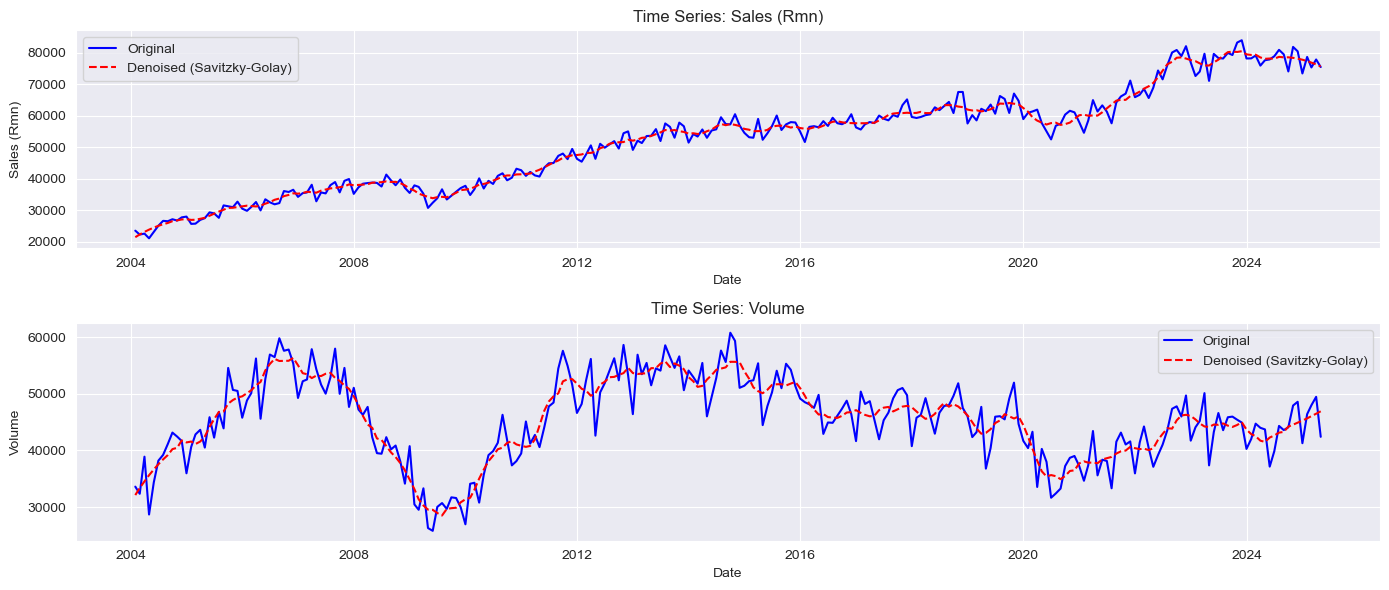

In [16]:
def savgol_denoiser(df, columns=None, window_length=15, polyorder=3, 
                    optimize=False, max_window=31, plot_cols=None, inplace=False):
    """
    Apply Savitzky-Golay filter to smooth selected columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        columns (list): Columns to denoise. If None, apply to all numeric.
        window_length (int): Length of the filter window (must be odd and > polyorder).
        polyorder (int): Polynomial order to fit within each window.
        optimize (bool): If True, searches for best (window_length, polyorder) by minimizing RMSE.
        max_window (int): Max window length to test if optimize=True (must be odd).
        plot_cols (list): Columns to plot comparison. Default = same as `columns`.
        inplace (bool): If True, replaces original df. Otherwise, returns copy.
    """
    df_denoised = df.copy()
    
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns.tolist()
    if plot_cols is None:
        plot_cols = columns

    for col in columns:
        signal = df[col].values

        if optimize:
            best_rmse, best_w, best_p = np.inf, None, None
            for w in range(5, min(len(signal), max_window), 2):  # only odd windows
                for p in range(1, min(w-1, 5)):  # reasonable polyorder range
                    try:
                        denoised_signal = savgol_filter(signal, window_length=w, polyorder=p)
                        rmse = np.sqrt(mean_squared_error(signal, denoised_signal))
                        if rmse < best_rmse:
                            best_rmse, best_w, best_p = rmse, w, p
                    except Exception:
                        continue
            window_length, polyorder = best_w, best_p
            print(f"[{col}] Optimal params: window={best_w}, polyorder={best_p}, RMSE={best_rmse:.4f}")

        denoised_signal = savgol_filter(signal, window_length=window_length, polyorder=polyorder)
        df_denoised[col] = denoised_signal

    # Clean column names
    df_denoised.columns = df_denoised.columns.str.strip()

    # Plot comparison
    if plot_cols:
        plt.figure(figsize=(14, 6))
        for i, col in enumerate(plot_cols, 1):
            plt.subplot(len(plot_cols), 1, i)
            plt.plot(df.index, df[col], label='Original', color='blue')
            plt.plot(df_denoised.index, df_denoised[col], label='Denoised (Savitzky-Golay)', 
                     color='red', linestyle='--')
            plt.title(f'Time Series: {col}')
            plt.xlabel('Date')
            plt.ylabel(col)
            plt.legend()
        plt.tight_layout()
        plt.show()

    if inplace:
        df.update(df_denoised)
        return df
    else:
        return df_denoised


# Apply to your data
denoised_df = savgol_denoiser(final_df, columns=["Sales (Rmn)", "Volume"], window_length=15, polyorder=2)

# Clean column names
denoised_df.columns = denoised_df.columns.str.strip()

# Make the denoised dataset the final dataset
final_df = denoised_df.copy()

### e. Data Engineering

In [17]:
# ---  COVID Dummy Variable ---
'''
    Now here we will create a dummy variable that indicates when covid started as
    it affected the data on such a large scale
'''
final_df['COVID_dummy'] = (final_df.index >= "2020-04-01").astype(int)
final_df.head()

,Sales (Rmn),Volume,ford_figo_queries_rising,golf_6_gti_queries_rising,golf_7_gti_queries_rising,gwm_queries_rising,hyundai_i10_queries_rising,hyundai_i20_queries_rising,polo_vivo_queries_rising,toyota_corolla_for_sale_queries_rising,...,volkswagen_tiguan_topics_rising,audi_topics_top,bmw_topics_top,car_topics_top,ford_topics_top,mercedes_topics_top,toyota_topics_top,volkswagen_topics_top,volkwagen_polo_topics_top,COVID_dummy
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,21509.997059,32112.473529,0,0,0,0,0,0,0,0,...,0,42,63,76,29,54,45,67,0,0
2004-02-29,22384.776891,33359.892017,0,0,0,0,0,0,0,0,...,0,53,56,79,33,57,42,58,0,0
2004-03-31,23182.816419,34528.224693,100,0,0,0,0,0,0,0,...,0,45,59,76,39,53,44,35,0,0
2004-04-30,23904.115643,35617.471558,0,0,0,0,0,0,0,0,...,0,37,51,64,30,42,46,65,0,0
2004-05-31,24548.674564,36627.632612,0,0,0,0,0,0,0,0,...,0,37,55,75,31,54,48,58,0,0


### f. Dataset Split

In [44]:
# For Scaled Data
X = final_df.drop(columns=['Sales (Rmn)', 'Volume'])
y1 = final_df['Sales (Rmn)']
y2 = final_df['Volume']

# TimeSeriesSplit (last fold will be used for train/test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    X1_train, X1_test = X.iloc[train_idx], X.iloc[test_idx]
    X2_train, X2_test = X.iloc[train_idx], X.iloc[test_idx]
    y1_train, y1_test = y1.iloc[train_idx], y1.iloc[test_idx]
    y2_train, y2_test = y2.iloc[train_idx], y2.iloc[test_idx]

### g. ADF Test

In [45]:
# --- ADF Test Function ---
def adf_test(series, title=''):
    """
    Run Augmented Dickey-Fuller test with clean output.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis → Stationary.\n")
    else:
        print("Weak evidence against the null hypothesis → Non-stationary.\n")

In [46]:
# --- Run ADF Test for Train ---
adf_test(y1_train, 'Sales (Rmn) - Train')
adf_test(y2_train, 'Volume - Train')

# --- Run ADF Test for Test ---
adf_test(y1_test, 'Sales (Rmn) - Test')
adf_test(y2_test, 'Volume - Test')

Augmented Dickey-Fuller Test: Sales (Rmn) - Train
ADF Statistic            -1.885602
p-value                   0.338864
# Lags Used              15.000000
# Observations          198.000000
Critical Value (1%)      -3.463815
Critical Value (5%)      -2.876251
Critical Value (10%)     -2.574611
Weak evidence against the null hypothesis → Non-stationary.

Augmented Dickey-Fuller Test: Volume - Train
ADF Statistic            -2.527773
p-value                   0.108862
# Lags Used              15.000000
# Observations          198.000000
Critical Value (1%)      -3.463815
Critical Value (5%)      -2.876251
Critical Value (10%)     -2.574611
Weak evidence against the null hypothesis → Non-stationary.

Augmented Dickey-Fuller Test: Sales (Rmn) - Test
ADF Statistic           -3.732603
p-value                  0.003677
# Lags Used              4.000000
# Observations          37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
Strong

In [ ]:
# ------------------------
# Function to difference non-stationary series and corresponding features
# ------------------------
def make_stationary(y_train, y_test, X_train=None, X_test=None, series_name="Series"):
    """
    Difference target and optionally features until stationary according to ADF test.
    Returns differenced y_train, y_test, X_train, X_test, and number of differences applied.
    """
    d = ndiffs(y_train.dropna(), test='adf')
    print(f"Suggested differences for {series_name}: {d}")
    
    if d > 0:
        # Difference target
        y_train_diff = y_train.diff(d).dropna()
        y_test_diff = y_test.diff(d).dropna()
        
        # Difference features if provided
        if X_train is not None:
            X_train_diff = X_train.apply(lambda col: col.diff(d)).dropna()
            # Align y_train with X_train
            y_train_diff = y_train_diff.loc[X_train_diff.index]
        else:
            X_train_diff = None
        
        if X_test is not None:
            X_test_diff = X_test.apply(lambda col: col.diff(d)).dropna()
            # Align y_test with X_test
            y_test_diff = y_test_diff.loc[X_test_diff.index]
        else:
            X_test_diff = None
    else:
        y_train_diff, y_test_diff = y_train, y_test
        X_train_diff, X_test_diff = X_train, X_test

    # Optional: Run ADF test on transformed data
    adf_test(y_train_diff, f"{series_name} - Train (Differenced)")

    return y_train_diff, y_test_diff, X_train_diff, X_test_diff, d

# ------------------------
# Apply to Sales
# ------------------------
y1_train, y1_test, X1_train, X1_test, d_sales = make_stationary(
    y1_train, y1_test, X1_train, X1_test, series_name="Sales"
)

# ------------------------
# Apply to Volume
# ------------------------
y2_train, y2_test, X2_train, X2_test, d_volume = make_stationary(
    y2_train, y2_test, X2_train, X2_test, series_name="Volume"
)

Suggested differences for Sales: 1
Augmented Dickey-Fuller Test: Sales - Train (Differenced)
ADF Statistic            -3.591987
p-value                   0.005916
# Lags Used              15.000000
# Observations          197.000000
Critical Value (1%)      -3.463987
Critical Value (5%)      -2.876326
Critical Value (10%)     -2.574652
Strong evidence against the null hypothesis → Stationary.

Suggested differences for Volume: 1
Augmented Dickey-Fuller Test: Volume - Train (Differenced)
ADF Statistic            -3.238230
p-value                   0.017876
# Lags Used              15.000000
# Observations          197.000000
Critical Value (1%)      -3.463987
Critical Value (5%)      -2.876326
Critical Value (10%)     -2.574652
Strong evidence against the null hypothesis → Stationary.



### h. Granger Causality Tests

In [48]:
# === Granger causality tests (top N features) ===
def granger_test_summary_topN(X_train, y_train, maxlag=8, target_name="Target", top_n=20):
    """
    Run Granger causality tests for each predictor in X_train against y_train.
    Returns DataFrame of top N predictors based on minimum p-value.
    """
    results = []
    df = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
    df.columns = [target_name] + list(X_train.columns)

    before_count = X_train.shape[1]  # count features before

    for predictor in X_train.columns:
        try:
            combined = df[[target_name, predictor]].dropna()
            test_result = grangercausalitytests(combined, maxlag=maxlag, verbose=False)
            # Get minimum p-value across lags
            p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
            min_p = min(p_values)
            results.append((predictor, min_p))
        except Exception as e:
            print(f"\nSkipped {predictor}: {e}")

    results_df = pd.DataFrame(results, columns=["Predictor", "Min_pvalue"]).sort_values("Min_pvalue")

    after_count = results_df.shape[0]  # count features after

    print(f"\n=== {target_name} Granger Causality Test Summary ===")
    print(f"Features before test: {before_count}")
    print(f"Top {top_n} features based on minimum p-value:")

    top_features = results_df.head(top_n)
    for _, row in top_features.iterrows():
        print(f"- {row['Predictor']} (p={row['Min_pvalue']:.4f})")

    return top_features


# === Run Granger causality on training set ===
# Sales
sales_top = granger_test_summary_topN(X1_train, y1_train, maxlag=1, target_name="Sales", top_n=20)
sales_predictors = sales_top["Predictor"].tolist()

# Volume
volume_top = granger_test_summary_topN(X2_train, y2_train, maxlag=2, target_name="Volume", top_n=20)
volume_predictors = volume_top["Predictor"].tolist()


# === Reduce datasets ===
# Sales
X1_train = X1_train[sales_predictors]
X1_test = X1_test[sales_predictors]

# Volume
X2_train = X2_train[volume_predictors]
X2_test = X2_test[volume_predictors]


Skipped volkwagen_polo_topics_top: The x values include a column with constant values and so the test statistic cannot be computed.

=== Sales Granger Causality Test Summary ===
Features before test: 42
Top 20 features based on minimum p-value:
- honda_queries_top (p=0.0222)
- gwm_queries_rising (p=0.1267)
- polo_vivo_queries_rising (p=0.1274)
- cars_for_sale_queries_top (p=0.1380)
- vw_queries_top (p=0.1585)
- cars_queries_top (p=0.1714)
- toyota_queries_top (p=0.2760)
- toyota_topics_top (p=0.2760)
- autotrader_queries_top (p=0.2879)
- golf_7_gti_queries_rising (p=0.3038)
- bmw_topics_rising (p=0.3093)
- bmw_queries_top (p=0.3093)
- bmw_topics_top (p=0.3093)
- webuycars_queries_rising (p=0.3345)
- toyota_corolla_for_sale_queries_rising (p=0.3540)
- opel_queries_top (p=0.3773)
- COVID_dummy (p=0.4853)
- ford_queries_top (p=0.4969)
- ford_topics_top (p=0.4969)
- audi_topics_top (p=0.5082)

Skipped volkwagen_polo_topics_top: The x values include a column with constant values and so the

In [49]:
# === Reduce datasets ===
# Sales
X1_train = X1_train[sales_predictors]
X1_test = X1_test[sales_predictors]

# Volume
X2_train = X2_train[volume_predictors]
X2_test = X2_test[volume_predictors]

### i. Feature Importance/Selection

In [50]:
def filter_features_by_importance(X, y, threshold=0.05, n_estimators=200, n_repeats=30, random_state=42):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)

    # Compute Permutation Importance
    pfi = permutation_importance(rf, X, y, n_repeats=n_repeats, random_state=random_state)

    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(pfi.importances_mean)
    }).sort_values(by='Importance', ascending=False)

    # Ensure it's a list, not a Series
    important_features = importance_df.loc[importance_df['Importance'] > threshold, 'Feature'].tolist()

    X_filtered = X[important_features]

    print(f"\nNumber of features before filtering: {X.shape[1]}")
    print(f"Number of features after filtering: {X_filtered.shape[1]}")
    print(f"Number of features dropped: {X.shape[1] - X_filtered.shape[1]}")
    print("="*60)
    print("Top 10 Permutation Feature Importances:")
    print(importance_df.head(10))

    return important_features, importance_df

In [51]:
# --- Sales ---
sales_final_features, sales_importance_df = filter_features_by_importance(X1_train, y1_train)

# Update all splits with final features
X1_train = X1_train[sales_final_features]
X1_test  = X1_test[sales_final_features]


Number of features before filtering: 20
Number of features after filtering: 13
Number of features dropped: 7
Top 10 Permutation Feature Importances:
                                   Feature  Importance
8                   autotrader_queries_top    0.153756
4                           vw_queries_top    0.129662
3                cars_for_sale_queries_top    0.118241
14  toyota_corolla_for_sale_queries_rising    0.117262
13                webuycars_queries_rising    0.096125
6                       toyota_queries_top    0.095240
15                        opel_queries_top    0.091458
7                        toyota_topics_top    0.083464
0                        honda_queries_top    0.066535
1                       gwm_queries_rising    0.065915


In [52]:
# --- Volume ---
volume_final_features, volume_importance_df = filter_features_by_importance(X2_train, y2_train)

# Update all splits with final features
X2_train = X2_train[volume_final_features]
X2_test  = X2_test[volume_final_features]


Number of features before filtering: 20
Number of features after filtering: 10
Number of features dropped: 10
Top 10 Permutation Feature Importances:
                                   Feature  Importance
12                  autotrader_queries_top    0.189697
17                   volkswagen_topics_top    0.175215
4                          kia_queries_top    0.148852
2                        honda_queries_top    0.085795
3                         cars_queries_top    0.080526
11               cars_for_sale_queries_top    0.075866
15  toyota_corolla_for_sale_queries_rising    0.075175
19               golf_6_gti_queries_rising    0.072954
8                       suzuki_queries_top    0.068092
16                      nissan_queries_top    0.050141


### j. Data Scalling

In [53]:
# --- Step 1: Initialize scalers ---
X1_scaler = MinMaxScaler()
X2_scaler = MinMaxScaler()
y1_scaler = MinMaxScaler()
y2_scaler = MinMaxScaler()

# --- Step 2: Fit on training sets only, transform train and test ---

# Features
X1_train = pd.DataFrame(X1_scaler.fit_transform(X1_train), 
                               columns=X1_train.columns, index=X1_train.index)
X1_test = pd.DataFrame(X1_scaler.transform(X1_test), 
                              columns=X1_test.columns, index=X1_test.index)

X2_train = pd.DataFrame(X2_scaler.fit_transform(X2_train), 
                               columns=X2_train.columns, index=X2_train.index)
X2_test = pd.DataFrame(X2_scaler.transform(X2_test), 
                              columns=X2_test.columns, index=X2_test.index)

# Targets
y1_train = pd.Series(y1_scaler.fit_transform(y1_train.values.reshape(-1,1)).flatten(),
                            index=y1_train.index, name=y1_train.name)
y1_test = pd.Series(y1_scaler.transform(y1_test.values.reshape(-1,1)).flatten(),
                           index=y1_test.index, name=y1_test.name)

y2_train = pd.Series(y2_scaler.fit_transform(y2_train.values.reshape(-1,1)).flatten(),
                            index=y2_train.index, name=y2_train.name)
y2_test = pd.Series(y2_scaler.transform(y2_test.values.reshape(-1,1)).flatten(),
                           index=y2_test.index, name=y2_test.name)

In [54]:
y1_train.tail()

Date
2021-06-30    1.000000
2021-07-31    0.993594
2021-08-31    0.987969
2021-09-30    0.666581
2021-10-31    0.582079
Name: Sales (Rmn), dtype: float64

## 6. Save Final Resources

In [55]:
# === Create output folder if it doesn't exist ===
output_folder = Path("final_datasets")
output_folder.mkdir(parents=True, exist_ok=True)

# === Save datasets ===
final_df.to_excel(output_folder / "final_df.xlsx")

# Features
X1_train.to_excel(output_folder / "X1_train.xlsx")
X1_test.to_excel(output_folder / "X1_test.xlsx")

X2_train.to_excel(output_folder / "X2_train.xlsx")
X2_test.to_excel(output_folder / "X2_test.xlsx")

# Targets (convert Series to DataFrame to save)
y1_train.to_frame().to_excel(output_folder / "y1_train.xlsx")
y1_test.to_frame().to_excel(output_folder / "y1_test.xlsx")

y2_train.to_frame().to_excel(output_folder / "y2_train.xlsx")
y2_test.to_frame().to_excel(output_folder / "y2_test.xlsx")

print("Datasets saved successfully:")
for file in output_folder.iterdir():
    print(f"- {file.name}")

Datasets saved successfully:
- final_df.xlsx
- X1_test.xlsx
- X1_train.xlsx
- X2_test.xlsx
- X2_train.xlsx
- y1_test.xlsx
- y1_train.xlsx
- y2_test.xlsx
- y2_train.xlsx


In [56]:
output_folder = Path("final_scalers")
output_folder.mkdir(parents=True, exist_ok=True)

# Save fitted scalers to disk
joblib.dump(X1_scaler, output_folder / "X1_scaler.pkl")
joblib.dump(X2_scaler, output_folder / "X2_scaler.pkl")
joblib.dump(y1_scaler, output_folder / "y1_scaler.pkl")
joblib.dump(y2_scaler, output_folder / "y2_scaler.pkl")

print("Scalers saved successfully.")

Scalers saved successfully.
